In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2xy(df, feat_col=None, target_col=None, data_cols=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    target_col: indicates the columns where the target is.
    data_col: indicates where the data is located. If None, it means all columns (excpet the target)
    """
    no_data_cols = []
    if feat_col is not None: no_data_cols.append(feat_col[0] if is_listy(feat_col) else feat_col)
    if target_col is not None: no_data_cols.append(target_col[0] if is_listy(target_col) else target_col)
    if data_cols is None: data_cols = [col for col in df.columns if col not in no_data_cols]
    n_feats = len(df[feat_col].unique()) if feat_col is not None else 1
    data = df.iloc[:, data_cols].values
    _, seq_len = data.shape
    X = data.reshape(n_feats, -1, seq_len).transpose(1, 0, 2)
    if X.dtype == 'O': X = X.astype(np.float32)
    if target_col is not None: y = np.split(df[target_col].values, n_feats)[0]
    else: y = None
    return X, y

In [ ]:
#export
def SlidingWindow(window_length, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, horizon:int=0, seq_first:bool=True):
    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_length   = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
        get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
    if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
    get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
    get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
    if horizon == 0 and get_x is not None and get_y is not None:
        assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
        'you need to change either horizon, get_x or get_y to avoid leakage'
    wl = window_length
    ws = wl if stride is None else stride
    start = start if start is not None else np.random.choice(ws, 1)[0]
    def _inner(o):
        if isinstance(o, pd.DataFrame): 
            columns = o.columns.values if seq_first else o.T.columns.values
            o = o.values
            if o.ndim > 1: 
                if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
                elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
                else: _get_x = slice(None)
                _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
        elif o.ndim > 1: 
            _get_x = ifnone(get_x, slice(None))
            _get_y = ifnone(get_y, slice(None))
        if seq_first: o = o.T
        o = o.squeeze()
        _seq_len = o.shape[-1]
        assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
        x, y = [], []
        for i in range(start, _seq_len - wl - horizon + 1, ws):
            if o.ndim == 1: 
                x.append(o[..., slice(i, i + wl)])
                if get_y is not None or horizon > 0: 
                    y.append(o[..., slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
            else: 
                x.append(o[..., _get_x, slice(i, i + wl)])
                if get_y is not None or horizon > 0: 
                    y.append(o[..., _get_y, slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
        X = to3d(stack(x))
        if X.dtype == 'O': X = X.astype(np.float32)
        y = stack(y).squeeze() if y != [] else None
        return X, y
    return _inner

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#6) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),),(array([[5, 6, 7, 8, 9]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, start=None)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


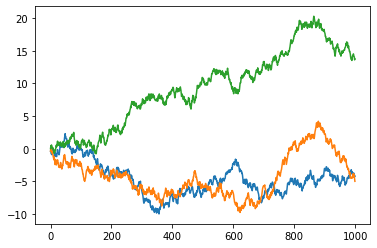

[(array([[-0.36342912, -0.27298444, -0.75402374, -0.75846458, -0.91547999],
       [-0.36872145,  0.01261391,  0.27992118, -0.21232455, -0.66283886]]), 0.40508386588353207), (array([[-0.61361811, -0.26018655, -0.44200751, -0.11319105, -0.16465478],
       [-0.55033337, -0.41851928, -0.88398648, -0.97571995, -1.25974211]]), -0.015635362124578056), (array([[-0.43402904, -0.55573201, -0.73372969, -1.17066951, -0.77656368],
       [-1.43372791, -1.70598576, -1.22338856, -1.61637036, -1.968509  ]]), -0.42831802191375434), (array([[-0.57232443, -1.04904162, -1.17632181, -0.76383964, -1.11467951],
       [-2.43954864, -2.1361938 , -1.70255895, -2.19257344, -2.50059971]]), 0.5385772951656157), (array([[-1.21873366, -0.88525135, -0.627299  , -0.14778391, -0.58202978],
       [-2.13950783, -2.29064064, -1.96954889, -1.71258514, -2.03000779]]), 0.6759973116731467), (array([[-0.62066743, -0.7733648 , -0.90170031, -0.93904675, -0.65323309],
       [-2.08607213, -2.48047871, -2.79866307, -2.67416666

In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 3)


,var_0,var_1,target
0,-0.375126,0.214131,0.218846
1,-0.226735,0.210612,0.239393
2,-0.237074,-0.200192,0.534700
3,-0.413551,-0.558138,0.717729
4,-0.332498,-0.923571,1.084345
...,...,...,...
95,-2.010394,-6.307469,-1.815171
96,-1.938305,-5.885558,-2.098826
97,-1.576278,-6.363883,-1.714577
98,-1.710290,-6.537153,-1.217482


[(array([[-0.3751258 , -0.22673496, -0.23707379, -0.41355105, -0.33249775],
       [ 0.21413125,  0.21061169, -0.20019193, -0.55813769, -0.92357073]]), 1.0843453417749396), (array([[-0.22673496, -0.23707379, -0.41355105, -0.33249775, -0.59667373],
       [ 0.21061169, -0.20019193, -0.55813769, -0.92357073, -1.27921317]]), 1.0858566005214094), (array([[-0.23707379, -0.41355105, -0.33249775, -0.59667373, -0.29732847],
       [-0.20019193, -0.55813769, -0.92357073, -1.27921317, -1.00580353]]), 1.5428584700922143), (array([[-0.41355105, -0.33249775, -0.59667373, -0.29732847, -0.12990367],
       [-0.55813769, -0.92357073, -1.27921317, -1.00580353, -0.8361368 ]]), 1.3538460715267102), (array([[-0.33249775, -0.59667373, -0.29732847, -0.12990367, -0.52233357],
       [-0.92357073, -1.27921317, -1.00580353, -0.8361368 , -1.29509448]]), 1.3631892196367636), (array([[-0.59667373, -0.29732847, -0.12990367, -0.52233357, -0.2420056 ],
       [-1.27921317, -1.00580353, -0.8361368 , -1.29509448, -1.7

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.308657,-0.237985,-0.089001,0.182476,-0.477458
1,-0.621813,-0.044880,-0.462599,0.179338,-0.681298
2,-1.026648,0.247049,-0.147370,0.222873,-0.817461
3,-0.541563,0.660984,0.000047,0.313811,-1.130350
4,-0.411722,0.368107,-0.308616,0.662301,-0.994853
...,...,...,...,...,...
95,-6.735425,-0.126456,-5.516390,-3.048213,4.108801
96,-6.324514,0.068219,-5.197887,-2.576825,4.398320
97,-5.903185,0.377045,-4.721628,-2.448532,4.323173
98,-5.915320,0.363087,-5.084028,-2.867301,4.379463


[(array([[-3.08656943e-01, -6.21813419e-01, -1.02664827e+00,
        -5.41562643e-01, -4.11722024e-01],
       [-2.37985116e-01, -4.48795465e-02,  2.47049267e-01,
         6.60983567e-01,  3.68106763e-01],
       [-8.90011044e-02, -4.62598634e-01, -1.47369660e-01,
         4.72322541e-05, -3.08615981e-01],
       [ 1.82475525e-01,  1.79338181e-01,  2.22872510e-01,
         3.13811318e-01,  6.62300820e-01]]), -0.9948531631250396), (array([[-6.21813419e-01, -1.02664827e+00, -5.41562643e-01,
        -4.11722024e-01, -4.03637065e-01],
       [-4.48795465e-02,  2.47049267e-01,  6.60983567e-01,
         3.68106763e-01,  5.52975014e-01],
       [-4.62598634e-01, -1.47369660e-01,  4.72322541e-05,
        -3.08615981e-01, -5.17249118e-01],
       [ 1.79338181e-01,  2.22872510e-01,  3.13811318e-01,
         6.62300820e-01,  8.12054651e-01]]), -1.2729287256946966), (array([[-1.02664827e+00, -5.41562643e-01, -4.11722024e-01,
        -4.03637065e-01, -5.52027021e-01],
       [ 2.47049267e-01,  6.60

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.205745,0.578562,0.282128,0.066986,0.229934,-0.236559,0.019136,0.083344,-0.299814,-0.082357,...,2.739238,2.937968,3.167614,3.476966,3.341330,2.892038,2.461029,2.333988,2.604432,3.033007
var_1,0.321699,-0.093834,-0.114444,-0.398882,-0.384045,-0.647591,-0.742356,-0.854054,-1.336807,-1.477035,...,-0.531012,-0.486866,-0.351101,-0.846073,-1.041681,-1.401417,-0.945309,-1.068146,-1.230573,-0.957098
var_2,-0.176767,-0.572996,-0.989164,-1.051206,-0.628953,-0.559021,-0.098909,0.237323,0.363957,0.553972,...,4.161006,4.641165,4.206452,4.451646,4.489664,4.752940,4.562920,4.373019,4.618680,4.602346
var_3,0.091888,0.571060,0.312074,0.410874,0.306981,0.481509,0.245536,0.109124,0.557806,0.677907,...,4.048728,4.504499,4.683949,4.253542,4.243389,4.730780,4.967830,5.121518,5.196138,5.359029
target,-0.146054,-0.110449,-0.199029,0.014657,0.170410,0.034491,0.433600,0.583873,0.912739,1.200806,...,0.938849,1.397544,1.311130,1.533362,1.414652,0.988170,0.777059,0.843406,0.667414,0.887658


[(array([[ 0.20574451,  0.57856221,  0.2821278 ,  0.06698564,  0.22993362],
       [ 0.32169929, -0.09383406, -0.11444406, -0.39888158, -0.38404485],
       [-0.17676653, -0.57299569, -0.98916415, -1.05120646, -0.62895268],
       [ 0.09188815,  0.57106034,  0.31207435,  0.41087385,  0.30698123]]), 0.17040989729588996), (array([[ 0.57856221,  0.2821278 ,  0.06698564,  0.22993362, -0.23655896],
       [-0.09383406, -0.11444406, -0.39888158, -0.38404485, -0.64759125],
       [-0.57299569, -0.98916415, -1.05120646, -0.62895268, -0.55902067],
       [ 0.57106034,  0.31207435,  0.41087385,  0.30698123,  0.48150883]]), 0.03449064345237485), (array([[ 0.2821278 ,  0.06698564,  0.22993362, -0.23655896,  0.01913632],
       [-0.11444406, -0.39888158, -0.38404485, -0.64759125, -0.74235586],
       [-0.98916415, -1.05120646, -0.62895268, -0.55902067, -0.09890913],
       [ 0.31207435,  0.41087385,  0.30698123,  0.48150883,  0.24553561]]), 0.4335999319093323), (array([[ 0.06698564,  0.22993362, -0

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.393138,-0.485218,-0.275419,-0.437736,-0.919188,-0.842534,-1.290250,-0.898214,-1.063971,-1.106297,...,-2.575045,-3.044385,-3.006177,-2.546770,-2.875118,-2.789655,-2.481294,-2.416872,-1.953052,-2.411312
var_1,0.293748,-0.083552,-0.518654,-0.031411,-0.065083,0.130995,0.577480,0.790467,0.422890,0.293942,...,4.005010,3.520435,3.863817,3.670111,3.412984,3.190057,3.126700,2.692256,3.103249,3.154739
var_2,-0.089297,-0.545834,-0.228050,-0.060675,-0.428937,-0.384231,-0.693068,-0.832800,-1.032796,-0.706603,...,-3.843269,-4.100229,-3.659084,-3.491833,-3.963074,-3.652364,-3.753929,-3.979659,-3.632075,-3.604698
var_3,0.429288,0.479325,0.233779,-0.213141,-0.457606,-0.609278,-0.955291,-0.757280,-0.267352,0.143771,...,1.221525,1.306391,1.787515,1.613946,2.012468,1.577371,1.231654,1.016597,0.935727,0.568177
target,0.268066,0.070366,0.083174,-0.159312,-0.591824,-0.559110,-0.305451,-0.783664,-1.211120,-1.191095,...,-1.470021,-1.639899,-1.780070,-1.429630,-1.813489,-1.823208,-1.695963,-1.375916,-1.711947,-2.072239


[(array([[-0.393138  , -0.48521834, -0.27541905, -0.43773613, -0.9191881 ],
       [ 0.29374848, -0.08355205, -0.51865364, -0.0314105 , -0.06508311],
       [-0.08929715, -0.54583359, -0.2280504 , -0.06067461, -0.42893696],
       [ 0.42928804,  0.4793246 ,  0.23377887, -0.21314116, -0.45760641]]), -0.5918237575590082), (array([[-0.84253421, -1.29025031, -0.89821411, -1.06397141, -1.10629686],
       [ 0.13099524,  0.57748013,  0.7904666 ,  0.42289044,  0.29394201],
       [-0.38423134, -0.69306831, -0.83280019, -1.03279584, -0.70660329],
       [-0.60927828, -0.95529126, -0.75727964, -0.26735172,  0.14377078]]), -1.1910954362441974), (array([[-0.66749712, -1.1594527 , -1.22737861, -1.218165  , -0.97149892],
       [ 0.65165261,  0.53982418,  0.5550245 ,  0.3168424 ,  0.60343627],
       [-1.00430315, -0.74719136, -0.74683317, -1.10992324, -0.81379192],
       [ 0.41921911,  0.33483646,  0.46688547,  0.16837748,  0.15646431]]), -1.6202626101896764), (array([[-1.43362149, -1.50431989, -

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.093879,-0.071736,-0.335066,-0.204274,-0.484208
1,0.556203,-0.385488,0.003437,0.190744,-0.202493
2,0.655655,-0.721856,-0.184006,0.283295,-0.540088
3,0.552480,-0.926468,0.192228,0.185783,-0.477791
4,0.885050,-1.419872,0.240994,-0.233844,-0.839579
...,...,...,...,...,...
95,5.163063,-0.572209,2.428837,2.189160,-5.021779
96,5.594760,-0.399931,2.242557,2.233077,-4.538271
97,5.779756,0.100035,2.319011,2.310338,-4.883866
98,5.306297,0.254745,1.894941,2.456241,-5.012788


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.semi_supervised.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.MLP.ipynb.
Converted 103b_models.FCN.ipynb.
Converted 103c_models.FCNPlus.ipynb.
Converted 104_models.ResCNN.ipynb.
Converted 105_models.R

In [ ]:
from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
df, _ = load_robot_execution_failures()
df.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [ ]:
X = extract_features(df, n_jobs=8, column_id='id', column_sort='time', default_fc_parameters=ComprehensiveFCParameters)

Feature Extraction: 100%|██████████| 39/39 [00:24<00:00,  1.58it/s]


In [ ]:
X = extract_features(df, n_jobs=8, column_id='id', column_sort='time', default_fc_parameters=EfficientFCParameters())

Feature Extraction: 100%|██████████| 38/38 [00:23<00:00,  1.62it/s]


In [ ]:
X = extract_features(df, n_jobs=8, column_id='id', column_sort='time', default_fc_parameters=EfficientFCParameters())

In [ ]:
X = extract_features(df, n_jobs=8, column_id='id', column_sort='time', default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|██████████| 38/38 [00:00<00:00, 99.96it/s]


In [ ]:
X = extract_features(df, n_jobs=8, column_id='id', default_fc_parameters=ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 39/39 [00:29<00:00,  1.34it/s]


In [ ]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
ComprehensiveFCParameters()

{'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variation_coefficient': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length': None,
 'sample_entropy': N

In [ ]:
for d in [ComprehensiveFCParameters(), MinimalFCParameters(), EfficientFCParameters()]: print(len(d))

71
8
69


In [ ]:
MinimalFCParameters()

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}